In [ ]:
!pip install libauc

In [ ]:
!unzip /content/drive/MyDrive/CHEXPERT/CheXpert-v1.0-small.zip > /dev/null

In [ ]:
!unzip /content/timm.zip > /dev/null
!unzip /content/layers.zip > /dev/null

unzip:  cannot find or open /content/timm.zip, /content/timm.zip.zip or /content/timm.zip.ZIP.
unzip:  cannot find or open /content/layers.zip, /content/layers.zip.zip or /content/layers.zip.ZIP.


In [ ]:
df = pd.read_csv('/content/CheXpert-v1.0-small/valid.csv')

In [ ]:
from pandas.core.frame import DataFrame
df = df[df['Frontal/Lateral']== 'Frontal']
df = df['Path']
df = pd.DataFrame(df)
df.to_csv('df.csv' , index = False)

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.1 MB/s 


In [ ]:
import torch

In [ ]:
import timm

In [ ]:
import sys
import csv
import time
import IPython

import cv2
import numpy as np 
import pandas as pd
from torch import nn


import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler


from sklearn.metrics import roc_auc_score

#cuda = torch.device('cuda:0')
# from libauc.losses import AUCM_MultiLabel
# from libauc.optimizers import PESG
#from chexpert import CheXpert
# from chexpert import CheXpert
from myGen_v7 import MyGen
from  myGen import MyGen_1


# from torchvision.models import densenet121
# from torchvision.models import densenet161
from torchvision.models import efficientnet_b0
from chexpert_2 import Chex


In [ ]:
    test_CA =  MyGen_1(csv_path='/content/df.csv', 
                 image_size=320)
     
    loader_CA =  torch.utils.data.DataLoader(test_CA, batch_size=1, num_workers=1, shuffle=False)


    test_ED =  MyGen(csv_path='/content/df.csv', 
                 image_size=256, 
                 use_clahe= False ,
                 use_fourier = False ,
                 use_histoeq = False,
                 use_decomposition = False,
                 use_godec = True,
                 use_top_bottom= False 
                 )
    loader_ED =  torch.utils.data.DataLoader(test_ED, batch_size=1, num_workers=1, shuffle=False)


    test_CON =  MyGen_1(csv_path='/content/df.csv', 
                 image_size=320
                 )
    loader_CON =  torch.utils.data.DataLoader(test_CON, batch_size=1, num_workers=1, shuffle=False)

    test_AT =   MyGen_1(csv_path='/content/df.csv', 
                 image_size=320
                 )
    
    loader_AT =  torch.utils.data.DataLoader(test_AT, batch_size=1, num_workers=1, shuffle=False)


    test_PE =  MyGen(csv_path='/content/df.csv', 
                 image_size=256, 
                 use_clahe= False ,
                 use_fourier = True ,
                 use_histoeq = False,
                 use_decomposition = False,
                 use_godec = False,
                 use_top_bottom= False 
                 )
    loader_PE =  torch.utils.data.DataLoader(test_PE, batch_size=1, num_workers=1, shuffle=False)
    
    print('LOADING FRONTAL MODELS')
    # LOADING FRONTAL MODELS
    load_CA= '/content/drive/MyDrive/ZT/CA/T_MobileNet_v3_320.pth'
    load_ED = '/content/drive/MyDrive/CHEXPERT/rexnet_150_godec_New.pth'
    load_CON ='/content/drive/MyDrive/ZT/CON/Z_resnet152_320.pth'
    load_AT='/content/drive/MyDrive/ZT/AT/Z_resnet50_320.pth'
    load_PE= '/content/drive/MyDrive/smsm/Fourier/PE_256_0955_EFF_B0_pretrained.pth'




    model_CA = timm.create_model('mobilenetv3_large_100_miil', num_classes=5, pretrained=False)
    model_ED = timm.create_model('rexnet_150', num_classes=1, pretrained=False)
    model_CON =timm.create_model('resnet152', num_classes=5, pretrained=False)
    model_At = timm.create_model('resnet50', num_classes=5, pretrained=False)
    model_PE = efficientnet_b0(pretrained=False)
    model_PE = nn.Sequential(*list(model_PE.children())[:-1] ,nn.Flatten(),nn.Linear(in_features=1280, out_features=1) ,nn.Sigmoid()).cuda()

                        
    model_CA = model_CA.cuda()
    model_ED = model_ED.cuda()
    model_CON = model_CON.cuda()
    model_At = model_At.cuda()
    model_PE = model_PE.cuda()


    model_CA.load_state_dict(torch.load(load_CA))
    model_ED.load_state_dict(torch.load(load_ED))
    model_CON.load_state_dict(torch.load(load_CON))
    model_At.load_state_dict(torch.load(load_AT))
    model_PE.load_state_dict(torch.load(load_PE))


    print('LOADING LATERAL MODELS')
    # LOADING LATERAL MODELS
    lat_load_CA= '/content/drive/MyDrive/smsm/D7hk/AP_lat/Lateral_320_rexnet_200.pth'
    lat_load_ED = '/content/drive/MyDrive/smsm/D7hk/AP_lat/ED_96226_Lateral_320_rexnet_200.pth'
    lat_load_CON ='/content/drive/MyDrive/smsm/D7hk/AP_lat/CON_95824_Lateral_320_mobilenetv2_100.pth'
    lat_load_AT='/content/drive/MyDrive/smsm/D7hk/AP_lat/AT_89018_Lateral_320_efficientnet_b1_Z.pth'
    lat_load_PE= '/content/drive/MyDrive/smsm/D7hk/AP_lat/PE_9533_Lateral_320_resnet50.pth'




    lat_model_CA = timm.create_model('rexnet_200', num_classes=5, pretrained=False)
    lat_model_ED = timm.create_model('rexnet_200', num_classes=1, pretrained=False)
    lat_model_CON =timm.create_model('mobilenetv2_100', num_classes=1, pretrained=False)
    lat_model_At = timm.create_model('efficientnet_b1', num_classes=1, pretrained=False)
    lat_model_PE = timm.create_model('resnet50', num_classes=1, pretrained=False)

                        
    lat_model_CA = lat_model_CA.cuda()
    lat_model_ED = lat_model_ED.cuda()
    lat_model_CON = lat_model_CON.cuda()
    lat_model_At = lat_model_At.cuda()
    lat_model_PE = lat_model_PE.cuda()


    lat_model_CA.load_state_dict(torch.load(lat_load_CA))
    lat_model_ED.load_state_dict(torch.load(lat_load_ED))
    lat_model_CON.load_state_dict(torch.load(lat_load_CON))
    lat_model_At.load_state_dict(torch.load(lat_load_AT))
    lat_model_PE.load_state_dict(torch.load(lat_load_PE))




    print('PREDICTING STARTED, It ')

    model_CA.eval()
    model_ED.eval()
    model_CON.eval()
    model_At.eval()
    model_PE.eval()

    lat_model_CA.eval()
    lat_model_ED.eval()
    lat_model_CON.eval()
    lat_model_At.eval()
    lat_model_PE.eval()


    with torch.no_grad():    
        pred_CA = []
        pred_ED = []
        pred_CON = []
        pred_AT = []
        pred_PE = []

        lat_pred_CA = []
        lat_pred_ED = []
        lat_pred_CON = []
        lat_pred_AT = []
        lat_pred_PE = []


        for test_1 in loader_CA:
            test_1 = test_1.cuda()
            y_CA = model_CA(test_1)
            y_CA = torch.sigmoid(y_CA)
            pred_CA.append(y_CA.cpu().detach().numpy())          
        pred_CA = np.concatenate(pred_CA)
        pred_CA = pred_CA[:,0].reshape(-1,1)  


        for test_2 in loader_ED:
            test_2 = test_2.cuda()
            y_ED = model_ED(test_2)
            y_ED = torch.sigmoid(y_ED)
            pred_ED.append(y_ED.cpu().detach().numpy())          
        pred_ED = np.concatenate(pred_ED)


        for test_3 in loader_CON:
            test_3 = test_3.cuda()
            y_CON = model_CON(test_3)
            y_CON = torch.sigmoid(y_CON)
            pred_CON.append(y_CON.cpu().detach().numpy())               
        pred_CON = np.concatenate(pred_CON)
        pred_CON = pred_CON[:,2].reshape(-1,1)  
        


        for test_4 in loader_AT:
            test_4 = test_4.cuda()
            y_AT = model_At(test_4)
            y_AT = torch.sigmoid(y_AT)
            pred_AT.append(y_AT.cpu().detach().numpy())          
        pred_AT = np.concatenate(pred_AT)
        pred_AT = pred_AT[:,3].reshape(-1,1)  



        for test_5 in loader_PE:
            test_5 = test_5.cuda()
            y_PE = model_PE(test_5)
            # y_PE = torch.sigmoid(y_PE)
            pred_PE.append(y_PE.cpu().detach().numpy())          
        pred_PE = np.concatenate(pred_PE) 


        ########### Lateral #############
        for lat_test_1 in loader_CON:
            lat_test_1 = lat_test_1.cuda()
            lat_y_CA = lat_model_CA(lat_test_1)
            lat_y_CA = torch.sigmoid(lat_y_CA)
            lat_pred_CA.append(lat_y_CA.cpu().detach().numpy())               
        lat_pred_CA = np.concatenate(lat_pred_CA)
        lat_pred_CA = lat_pred_CA[:,0].reshape(-1,1) 


        for lat_test_2 in loader_CON:
            lat_test_2 = lat_test_2.cuda()
            lat_y_ED = lat_model_ED(lat_test_2)
            lat_y_ED = torch.sigmoid(lat_y_ED)
            lat_pred_ED.append(lat_y_ED.cpu().detach().numpy())               
        lat_pred_ED = np.concatenate(lat_pred_ED)



        for lat_test_3 in loader_CON:
            lat_test_3 = lat_test_3.cuda()
            lat_y_CON = lat_model_CON(lat_test_3)
            lat_y_CON = torch.sigmoid(lat_y_CON)
            lat_pred_CON.append(lat_y_CON.cpu().detach().numpy())               
        lat_pred_CON = np.concatenate(lat_pred_CON)      


        for lat_test_4 in loader_CON:
            lat_test_4 = lat_test_4.cuda()
            lat_y_AT = lat_model_At(lat_test_4)
            lat_y_AT = torch.sigmoid(lat_y_AT)
            lat_pred_AT.append(lat_y_AT.cpu().detach().numpy())               
        lat_pred_AT = np.concatenate(lat_pred_AT) 

        for lat_test_5 in loader_CON:
            lat_test_5 = lat_test_5.cuda()
            lat_y_PE = lat_model_PE(lat_test_5)
            lat_y_PE = torch.sigmoid(lat_y_PE)
            lat_pred_PE.append(lat_y_PE.cpu().detach().numpy())               
        lat_pred_PE = np.concatenate(lat_pred_PE) 


        test_pred = np.concatenate((pred_CA, pred_ED, pred_CON, pred_AT, pred_PE) , axis = 1)
        lat_test_pred = np.concatenate((lat_pred_CA, lat_pred_ED, lat_pred_CON, lat_pred_AT, lat_pred_PE) , axis = 1)



LOADING FRONTAL MODELS


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


LOADING LATERAL MODELS
PREDICTING STARTED, It 


In [ ]:
content_front = np.concatenate((test_CA.get_path, test_pred), axis=1) 
content_lat = np.concatenate((test_CA.get_path, lat_test_pred), axis=1) 
content = []
for idx in range (len(content_front)):
    path = content_front[idx, 0].split('/')
    view_type = path[-1]
    if 'lateral' in view_type:  
      content.append(content_lat[idx, :])
    else :
      content.append(content_front[idx, :])
content = np.array(content)

In [ ]:
Root= '/content/CheXpert-v1.0-small/'

In [ ]:
Lala =  Chex(csv_path=Root+'valid.csv', train_cols=['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion'],image_root_path=Root, use_upsampling=False, use_frontal=False ,image_size=224, mode='valid',shuffle=False , class_index=-1, verbose=False)
ALL =  torch.utils.data.DataLoader(Lala, batch_size=1, num_workers=1, shuffle=False)



/content/chexpert_2.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0-small/', '')
/content/chexpert_2.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0/', '')


In [ ]:
test_true = [] 


In [ ]:
for jdx, data in enumerate(ALL):
    test_data, test_labels = data
    test_true.append(test_labels.cpu().numpy())
test_true = np.concatenate(test_true)


In [ ]:
Hero = content[: , 1:]

In [ ]:
labels = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']

results = pd.DataFrame(index=labels)


scores = []
for i in range(5):
    score = roc_auc_score(test_true[:, i], Hero[:, i])
    scores.append(score)
    
results['AUC'] = scores

In [ ]:
results.mean()

AUC    0.932748
dtype: float64

In [ ]:
results

,AUC
Cardiomegaly,0.899717
Edema,0.962257
Consolidation,0.958239
Atelectasis,0.890179
Pleural Effusion,0.953347


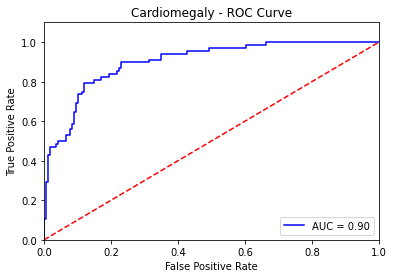

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, threshold = roc_curve(test_true[:, 0], Hero[:, 0])
roc_auc = auc(fpr, tpr)

plt.title('Cardiomegaly - ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('Cardiomegaly Curve', bbox_inches='tight')
plt.show()

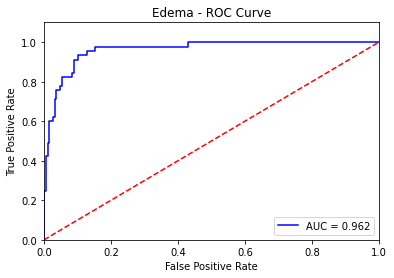

In [ ]:
fpr, tpr, threshold = roc_curve(test_true[:, 1], Hero[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc = auc(fpr, tpr)
plt.title('Edema - ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('Edema Curve', bbox_inches='tight')
plt.show()

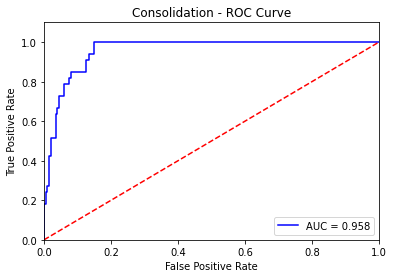

In [ ]:
fpr, tpr, threshold = roc_curve(test_true[:, 2], Hero[:, 2])
roc_auc = auc(fpr, tpr)
roc_auc = auc(fpr, tpr)
plt.title('Consolidation - ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('Edema Curve', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


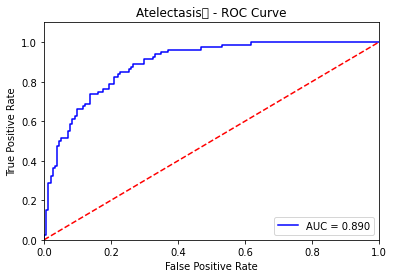

In [ ]:
fpr, tpr, threshold = roc_curve(test_true[:, 3], Hero[:, 3])
roc_auc = auc(fpr, tpr)
roc_auc = auc(fpr, tpr)
plt.title('Atelectasis	 - ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('Edema Curve', bbox_inches='tight')
plt.show()

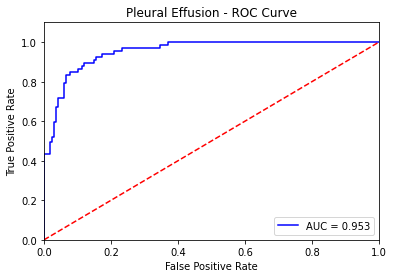

In [ ]:
fpr, tpr, threshold = roc_curve(test_true[:, 4], Hero[:, 4])
roc_auc = auc(fpr, tpr)
roc_auc = auc(fpr, tpr)
plt.title('Pleural Effusion - ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('Edema Curve', bbox_inches='tight')
plt.show()